# Task 4

Find the lowest eigenvalue of the following matrix:

$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0  \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

using VQE-like circuits, created by yourself from scratch.

# 1) Decomposing the desired matrix into pauli operators

Since we want to measure a VQE-like circuit, we need to decompose the matrix into their pauli components. We have that the pauli matrices are:

$$
\sigma_x = \begin{pmatrix}
    0 & 1 \\
    1 & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_y = \begin{pmatrix}
    0 & -i \\
    i & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_z = \begin{pmatrix}
    1 & 0 \\
    0 & -1
    \end{pmatrix}
$$

Thus to get the pauli component of a Matrix $2^N$ x $2^N$ matrix $A$, as stated on [stackoverflow](https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis), we have:

$$
A = \sum_{ij} \frac{1}{4} h_{ij} \hspace{0.5em} \sigma_i \otimes \sigma_j
$$

And the components $h_{ij}$ are:

$$
h_{ij} = \frac{1}{4} \mathrm{Tr} \bigg[ (\sigma_i \otimes \sigma_j) \cdot A \bigg]
$$

In [39]:
import numpy as np
A = np.array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])
print(A)
# Defining Pauli Matrices
pauli_x = np.array([[0,1],[1,0]]) ; pauli_y = np.array([[0,1j],[-1j,0]]) ; pauli_z = np.array([[1,0],[0,-1]])

name_basis = ['I', 'X', 'Y', 'Z']
basis = [np.eye(2), pauli_x, pauli_y, pauli_z]

[[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]


In [37]:
from itertools import product

def get_components_from_matrix(A, basis, name_basis):
    
    components = []
    components_names = []

    for (name_1, pauli_1),(name_2, pauli_2) in product(zip(name_basis, basis),zip(name_basis, basis)):
        components.append(1/4.*np.trace(np.kron(pauli_1,pauli_2) @ A))
        components_names.append(name_1 + name_2)
    return components, components_names

def clean_components(components, components_names):
    """Removes components with 0"""    
    cleaned_components = []
    cleaned_components_names = []

    for i in range(len(components)):
        if components[i] != 0.:
            cleaned_components.append(components[i])
            cleaned_components_names.append(components_names[i])
    return cleaned_components, cleaned_components_names


In [38]:
from itertools import product

components, components_names = get_components_from_matrix(A, basis, name_basis)
cleaned_components, cleaned_components_names = clean_components(components, components_names)

print("Decomposition:")
for name, comp in zip(components_names, components):
    print(f"  {name} : {comp}")

print("Clean decomposition:")
for name, comp in zip(cleaned_components_names, cleaned_components):
    print(f"  {name} : {comp}")


Decomposition:
  II : 0.5
  IX : 0.0
  IY : 0j
  IZ : 0.0
  XI : 0.0
  XX : -0.5
  XY : 0j
  XZ : 0.0
  YI : 0j
  YX : 0j
  YY : (-0.5+0j)
  YZ : 0j
  ZI : 0.0
  ZX : 0.0
  ZY : 0j
  ZZ : 0.5
Clean decomposition:
  II : 0.5
  XX : -0.5
  YY : (-0.5+0j)
  ZZ : 0.5


In [46]:
print("decomposition of A:")
print(f"""{
0.5*np.kron(np.eye(2), np.eye(2))  
- 0.5*np.kron(pauli_x, pauli_x) 
- 0.5*np.kron(pauli_y, pauli_y)  
+ 0.5*np.kron(pauli_z, pauli_z)}
""")

decomposition of A:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]



Now we know that the desired matrix, has the following pauli decomposition:

$$
A = 0.5 I \otimes I \ - \ 0.5 \sigma_x \otimes \sigma_x \ - \ 0.5 \sigma_y \otimes \sigma_y \ + \ 0.5 \sigma_z \otimes \sigma_z
$$

# 2) Creating VQE circuit

Now we want to construct the VQE and measure the pauli factors in order to get the lowest eigenvalue of $A$. This is done

## 2.1) Creating Ansatz

In order to create the Variational Ansatz, we need to create a parametrized circuit in Qiskit. This is done by using the `parameter` class in `qiskit.circuit`. 

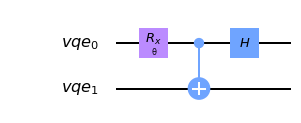

In [49]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

theta = Parameter('θ')

qr = QuantumRegister(2, name='vqe')
qc = QuantumCircuit(qr)
qc.rx(theta, qr[0])
qc.cx(qr[0], qr[1])
qc.h(qr[0])
qc.draw('mpl')

In [51]:
def measure_zz_circuit(circuit):
    """Measure the ZZ Component of the variational, circuit."""
    zz_meas = circuit.copy()
    zz_meas.measure_all()
    return zz_meas

zz_meas = measure_zz_circuit(qc)
zz_meas.draw()

┌───────┐     ┌───┐ ░ ┌─┐   
 vqe_0: ┤ RX(θ) ├──■──┤ H ├─░─┤M├───
        └───────┘┌─┴─┐└───┘ ░ └╥┘┌─┐
 vqe_1: ─────────┤ X ├──────░──╫─┤M├
                 └───┘      ░  ║ └╥┘
meas_0: ═══════════════════════╩══╬═
                                  ║ 
meas_1: ══════════════════════════╩═

In [1]:
from qiskit.tools.jupyter import *
%qiskit_version_table